In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, roc_auc_score, auc, precision_recall_curve
import lime
import lime.lime_tabular



# SMOTE

In [270]:
df = pd.read_csv("Datos_regresion.csv") # read in data downloaded to the local directory
df.head()

,Edad,Diag.Ing1,Diag.Ing2,Diag.Egr1,Diag.Egr2,APACHE,TiempoVAM,Fallece
0,35,1,0,1,0,10,2,0
1,87,2,0,2,0,16,2,0
2,70,4,0,4,0,11,2,0
3,24,13,0,13,5,11,2,0
4,24,3,0,3,0,17,3,0


In [271]:
# Verificamos si hay algún elemento nulo
df.isnull().sum()

Edad         0
Diag.Ing1    0
Diag.Ing2    0
Diag.Egr1    0
Diag.Egr2    0
APACHE       0
TiempoVAM    0
Fallece      0
dtype: int64

In [272]:
df.shape

(208, 8)

In [273]:
df.describe()

,Edad,Diag.Ing1,Diag.Ing2,Diag.Egr1,Diag.Egr2,APACHE,TiempoVAM,Fallece
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,54.192308,11.423077,7.990385,11.418269,10.139423,13.711538,5.865385,0.153846
std,18.983378,9.022454,8.792833,8.935791,8.781556,6.344648,10.697472,0.361672
min,17.000000,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000
25%,42.000000,4.000000,0.000000,4.000000,0.000000,9.000000,2.000000,0.000000
50%,56.000000,10.000000,6.000000,9.000000,10.000000,13.000000,3.000000,0.000000
75%,68.000000,14.000000,16.000000,14.000000,16.250000,18.000000,7.000000,0.000000
max,91.000000,40.000000,36.000000,40.000000,36.000000,36.000000,144.000000,1.000000


In [274]:
# Se crea un nuevo dataset con los datos de forma tal que puedan ser procesados por el algoritmo
df_new = df[["Edad", "APACHE", "TiempoVAM"]]
lista = ["Diag.Ing1", "Diag.Ing2", "Diag.Egr1", "Diag.Egr2"]
for i in lista:
    new = pd.get_dummies(df[i], prefix=i)
    df_new = pd.concat([df_new , new], axis = 1)
df_new = pd.concat([df_new , df.Fallece], axis =1)
df = df_new
df.head()

,Edad,APACHE,TiempoVAM,Diag.Ing1_1,Diag.Ing1_2,Diag.Ing1_3,Diag.Ing1_4,Diag.Ing1_5,Diag.Ing1_6,Diag.Ing1_7,...,Diag.Egr2_21,Diag.Egr2_22,Diag.Egr2_23,Diag.Egr2_24,Diag.Egr2_25,Diag.Egr2_27,Diag.Egr2_33,Diag.Egr2_34,Diag.Egr2_36,Fallece
0,35,10,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,87,16,2,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,70,11,2,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,24,11,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,24,17,3,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [275]:
df.shape

(208, 117)

In [276]:
# Tomamos un dato para predecir su probabilidad de morir
x_pred_f = df.loc[df.Fallece == 1]
x_pred_f = x_pred_f[1:2]
x_pred_f = x_pred_f.drop("Fallece", axis =1)

In [277]:
# Tomamos un dato para predecir su probabilidad de vivir
x_pred_v = df.loc[df.Fallece == 0]
x_pred_v = x_pred_v[:1]
x_pred_v = x_pred_v.drop("Fallece", axis =1)

In [278]:
df['Fallece'].value_counts(sort=True)

Fallece
0    176
1     32
Name: count, dtype: int64

Text(0, 0.5, 'Number of Observations')

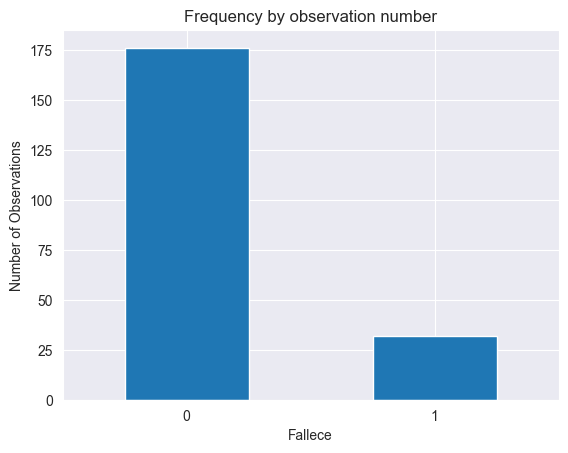

In [279]:
count_classes = df['Fallece'].value_counts(sort=True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.ylabel("Number of Observations")

In [280]:

# Crear un DataFrame a partir del resultado de value_counts()
table = pd.DataFrame({'Clase': count_classes.index, 'Count': count_classes.values})

# Ordenar el DataFrame por la columna 'Count'
table = table.sort_values(by='Count', ascending=False)

# Mostrar la tabla
print(table)


   Clase  Count
0      0    176
1      1     32


In [281]:
#definimos nuestras etiquetas y features
y = df['Fallece']
X = df.drop('Fallece', axis=1)

In [282]:
# Crear un objeto SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE al conjunto de entrenamiento
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# Imprimir la distribución antes y después del suavizado
print("Distribution before smoothing {}".format(Counter(y)))
print("Distribution labels after smoothing {}".format(Counter(y_train_resampled)))

Distribution before smoothing Counter({0: 176, 1: 32})
Distribution labels after smoothing Counter({0: 176, 1: 176})


In [283]:
#dividimos en sets de entrenamiento, test
#X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, train_size=0.8, random_state=42)

In [284]:
# Dividir los datos en conjunto de entrenamiento + validación y conjunto de prueba
X_train_val, X_test, y_train_val, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento + validación en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [285]:
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de validación:", len(X_val))
print("Tamaño del conjunto de prueba:", len(X_test))


Tamaño del conjunto de entrenamiento: 210
Tamaño del conjunto de validación: 71
Tamaño del conjunto de prueba: 71


In [286]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': [ 'l1', 'l2', None]
}

# Configurar la búsqueda en cuadrícula
clf = GridSearchCV(LogisticRegression(), param_grid, cv=5)
clf.fit(X_val, y_val)

# Realizar predicciones en el conjunto de prueba
#y_pred = clf.predict(X_test)

# Obtener los mejores parámetros
best_params = clf.best_params_

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:")
print(best_params)

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore th

Mejores parámetros encontrados:
{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore th

In [287]:
# Crear un nuevo modelo con los mejores hiperparámetros encontrados
best_lr_model = LogisticRegression(**best_params)

# Entrenar el modelo con el conjunto de datos completo de entrenamiento + validación
best_lr_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_lr_model.predict(X_test)

In [288]:
# Resultado del algorimo: [probabilidad de que viva: probabilidad de que muera]
prob = clf.predict_proba(X)
np.savetxt("prob.csv", prob, delimiter=',')

In [289]:
# Resultado del algorimo: [probabilidad de que viva: probabilidad de que muera]
prob = clf.predict_proba(x_pred_v)
prob

array([[0.9966095, 0.0033905]])

In [290]:
# Metricas
val_mae = mean_absolute_error(y_test , y_pred)
print("Validation MAE: {}".format(val_mae))

val_mse = mean_squared_error(y_test , y_pred)
print("Validation MSE: {}".format(val_mse))

val_rmse = mean_squared_error(y_test , y_pred, squared=False)
print("Validation RMSE: {}".format(val_rmse))

Validation MAE: 0.14084507042253522
Validation MSE: 0.14084507042253522
Validation RMSE: 0.37529331252040077


In [291]:
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

recall = recall_score(y_test, y_pred)
print("Recall Score:", recall)
# Obtener las probabilidades predichas en el conjunto de prueba
y_scores = clf.predict_proba(X_test)[:, 1]

# Calcular AUC-ROC
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC:", auc_roc)

precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)
print("AUC-PR:", auc_pr)

F1 Score: 0.84375
Recall Score: 0.8709677419354839
AUC-PR: 0.6731779099007429


In [292]:
# Cross Validation
print(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore th

0.8416666666666668


In [293]:
# from sklearn.model_selection import cross_val_score, KFold
# 
# kf = KFold(n_splits=10, shuffle=True, random_state=42)
# scores = cross_val_score(clf, X, y, cv=kf, scoring='accuracy')
# print(scores.mean())


In [294]:
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# 
# stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# scores = cross_val_score(clf, X, y, cv=stratified_kf, scoring='accuracy')
# print(scores.mean())


In [295]:
# from sklearn.model_selection import cross_val_score, TimeSeriesSplit
# 
# time_series_cv = TimeSeriesSplit(n_splits=10)
# scores = cross_val_score(clf, X, y, cv=time_series_cv, scoring='accuracy')
# print(scores.mean())


In [296]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score


# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['logistic', 'relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [100, 200, 300],
}

# Crear el objeto GridSearchCV con balanced_accuracy como métrica
mlp = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)

# Ajustar el modelo al conjunto de entrenamiento
mlp.fit(X_val, y_val)

# Obtener los mejores hiperparámetros
best_params = mlp.best_params_
print("Mejores hiperparámetros:", best_params)

# Predecir en el conjunto de prueba con el modelo ajustado
# y_pred = mlp.predict(X_test)

# Calcular la precisión balanceada en el conjunto de prueba
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Precisión balanceada en el conjunto de prueba:", balanced_accuracy)

Mejores hiperparámetros: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'max_iter': 300, 'solver': 'adam'}
Precisión balanceada en el conjunto de prueba: 0.8604838709677419


C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [297]:
best_mlp_model = MLPClassifier(**best_params)

best_mlp_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba con el modelo ajustado
y_pred = best_mlp_model.predict(X_test)

C:\Users\anportal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [298]:
# Metricas
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred, squared=False)}")

MAE: 0.2112676056338028
MSE: 0.2112676056338028
MSE: 0.4596385597769217


In [304]:
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

recall = recall_score(y_test, y_pred)
print("Recall Score:", recall)
# Obtener las probabilidades predichas en el conjunto de prueba
y_scores = mlp.predict_proba(X_test)[:, 1]

# Calcular AUC-ROC
auc_roc = roc_auc_score(y_test, y_scores)
print("AUC-ROC:", auc_roc)

precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)
print("AUC-PR:", auc_pr)

F1 Score: 0.7887323943661972
Recall Score: 0.9032258064516129
AUC-ROC: 0.8233870967741935
AUC-PR: 0.6713085110452051


In [300]:

# cv_scores = cross_val_score(best_model, X, y, cv=10, scoring='recall')
# print(cv_scores)

In [301]:
# Obtener nombres de características
feature_names = df.columns.tolist()

# Obtener nombres de clases (si estás trabajando en un problema de clasificación)
class_names = df['Fallece'].unique().tolist()  # Suponiendo que 'clase' es la columna de clases en tus datos


In [302]:
# Crear un objeto explainer LIME para datos tabulares
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=class_names)

# Seleccionar una instancia para explicar (por ejemplo, la primera instancia del conjunto de prueba)
instance = X_test[0]

# Explicar la predicción para la primera instancia del conjunto de prueba
explanation = explainer.explain_instance(instance, mlp.predict_proba, num_features=2)

InvalidIndexError: (slice(None, None, None), 0)